In [1]:
import os

PATH = '/home/stadlerm/Development/Projects/DreamChallenge/RA2_alpine_lads/ra_joint_predictions'

os.chdir(PATH)

In [2]:
from utils.config import Config

config = Config()

In [3]:
from dataset.joint_dataset import feet_joint_dataset

dataset = feet_joint_dataset(config)

feet_joints = dataset.create_feet_joints_dataset('../../train/training.csv', joints_source = './data/feet_joint_data.csv')

In [4]:
print(dataset.class_weights)

[{0: 0.5511732401397904, 1: 315.4285714285714, 2: 11.208121827411167, 3: 20.830188679245282, 4: 22.080000000000002}]


In [5]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

output_bias = tf.keras.initializers.Constant(dataset.class_bias)

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224 ,1)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation = 'softmax', bias_initializer = output_bias)
])

In [6]:
model.compile(loss=['categorical_crossentropy'], metrics=["accuracy"], optimizer='adam')

In [7]:
history = model.fit(
    feet_joints, epochs = 5, steps_per_epoch = 25, class_weight = dataset.class_weights[0]
)

Train for 25 steps
Epoch 1/5
25/25 [==============================] - 26s 1s/step - loss: 10.1089 - accuracy: 0.4368
Epoch 2/5
25/25 [==============================] - 22s 876ms/step - loss: 7.4813 - accuracy: 0.3232
Epoch 3/5
25/25 [==============================] - 21s 836ms/step - loss: 3.8958 - accuracy: 0.4384
Epoch 4/5
25/25 [==============================] - 23s 905ms/step - loss: 1.0207 - accuracy: 0.9824
Epoch 5/5
25/25 [==============================] - 21s 849ms/step - loss: 4.7624 - accuracy: 0.6960


tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float64)


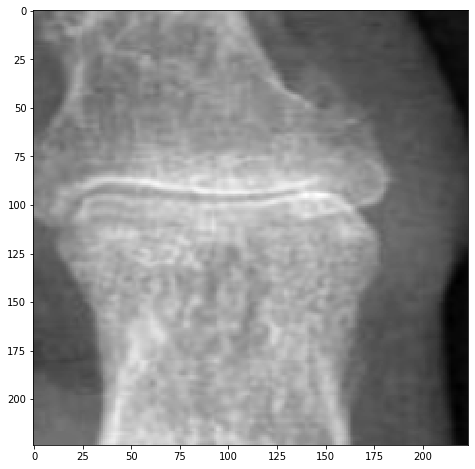

In [9]:
import matplotlib.pyplot as plt

for x, y in feet_joints.take(1):
    print(y[0])
    
    plt.figure(figsize = (8, 8))
    plt.imshow(x[0, :, :, 0], cmap="gray")
    plt.show()

In [9]:
from dataset.joint_dataset import rsna_joint_dataset

rsna_joint_dataset = rsna_joint_dataset(config).create_rsna_joints_dataset(val_split = False)

tf.Tensor([180   1], shape=(2,), dtype=int64)


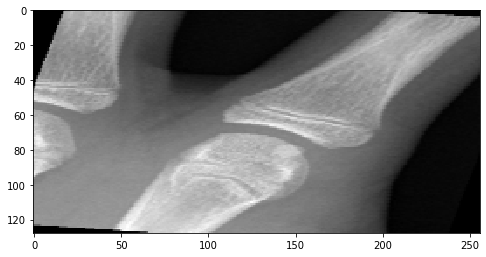

In [10]:
import matplotlib.pyplot as plt

for x, y in rsna_joint_dataset.take(1):
    print(y[0])
    
    plt.figure(figsize = (8, 8))
    plt.imshow(x[0, :, :, 0], cmap="gray")
    plt.show()

In [3]:
import tensorflow as tf
from utils import top_2_categorical_accuracy

dependencies = {
    'top_2_categorical_accuracy': top_2_categorical_accuracy
}

erosion_model = tf.keras.models.load_model('feet_erosion_model_complex_v4.h5', custom_objects=dependencies)

In [4]:
import pandas as pd
import numpy as np

from dataset.ops import dataset_ops as ds_ops
from dataset.ops import joint_ops

AUTOTUNE = tf.data.experimental.AUTOTUNE

full_val_data = pd.read_csv('./data/feet_joint_data_test.csv')

full_val_data['flip'] = 'N'
flip_idx = ['-R' in image_name for image_name in full_val_data['image_name']]
flip_columns = full_val_data['flip'].values
flip_columns[flip_idx] = 'Y'
full_val_data['flip'] = flip_columns

full_val_data['file_type'] = 'jpg'

file_info = full_val_data[['image_name', 'file_type', 'flip', 'key']].values

outcome_column = 'narrowing_0' 
outcomes = full_val_data[outcome_column]
outcomes = pd.get_dummies(outcomes, columns = [outcome_column])

coords = full_val_data[['coord_x', 'coord_y']].values

full_val_dataset = tf.data.Dataset.from_tensor_slices((file_info, coords, outcomes.to_numpy(dtype = np.float64)))
full_val_dataset = joint_ops.load_joints(full_val_dataset, '../train')
# full_val_dataset = ds_ops.cache_dataset(full_val_dataset, True)
full_val_dataset = ds_ops.resize_images(full_val_dataset, 256, 128, update_labels = False, pad_resize = False) 
full_val_dataset = full_val_dataset.prefetch(buffer_size = AUTOTUNE)   

In [5]:
import numpy as np

truths = np.array([], dtype = np.int32)
preds = np.array([], dtype = np.int32)
rmse_preds = np.array([], dtype = np.int32)

for x, y in full_val_dataset:
    y_pred = erosion_model.predict(tf.expand_dims(x, 0))
    
    rmse_pred = np.sum(y_pred * np.arange(5))
    
    y_pred = np.argmax(y_pred)
    
    truths = np.append(truths, np.argmax(y))
    preds = np.append(preds, y_pred)
    rmse_preds = np.append(rmse_preds, rmse_pred)

In [6]:
from sklearn.metrics import classification_report

print(classification_report(truths, preds))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       985
           1       0.00      0.00      0.00         2
           2       0.41      0.25      0.31        55
           3       0.33      0.12      0.17        34
           4       0.83      0.36      0.50        28

    accuracy                           0.90      1104
   macro avg       0.50      0.34      0.39      1104
weighted avg       0.88      0.90      0.88      1104



/home/stadlerm/Development/Programs/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
np.count_nonzero(truths == preds) / truths.size

0.9021739130434783

In [8]:
np.sqrt(np.mean(np.square(truths - preds)))

0.7848197429891193

In [9]:
np.sqrt(np.mean(np.square(truths - rmse_preds)))

0.7566249446001023

In [10]:
abs_e = np.absolute(truths - preds)

np.unique(abs_e, return_counts = True)

(array([0, 1, 2, 3, 4]), array([996,  15,  54,  25,  14]))